<a target="_blank" href="https://colab.research.google.com/github/go-bgc/2023-workshop-python/blob/main/BGC_one_float_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Download and visualise one BGC float data

## This notebook is adapted from a notebook written by Guillaume Maze, lead developer of [argopy](https://argopy.readthedocs.io/). Here we will:
- download and search the BGC-Argo index
- download info from Argo NVS Reference Tables about a parameter
- download BGC-Argo data for one float
- plot a map with float trajectory
- plot float data
- bin or interpolate data

The default data source used by argopy is the Ifremer Erddap server. The gdac and Argovis are also supported. You can check the status of each service at https://argopy.statuspage.io

## Instructions for setting up w/ Google Colab

**About Google Colab:**

Colab is a free, cloud-based Jupyter notebook platform.

Cells are either code or text. To run a cell, click the button at the top left of the cell, or type `Shift`-`Enter` or `Shift`-`Return` on your keyboard.

If something isn't working, you can restart your runtime using the command in the \"Runtime\" menu.

**Setup:**
 The first time you run the cell below, you'll be asked to navigate to a link. **Click on the link,** then give Colab permission to access Google Drive. Copy the authorization code and paste it into the Colab notebook. If you get the message, \"`Mounted at /content/drive`,\" you are ready to go!"

 The default colab environment includes almost everything needed. We can pip-install a few more packages
*note - the specific argopy version below is needed for bgc support*

In [ ]:
!pip install argopy==0.1.14rc2
!pip install colab-xterm
!pip install cmocean
!pip install cartopy
!pip install matplotlib

## Import and set-up

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # Functions to easily make maps and plots

# Make a fresh start
import argopy
argopy.set_options(cachedir='cache_bgc')
#argopy.reset_options()
argopy.clear_cache()

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
xr.set_options(display_expand_attrs = False)

## Find a float to work with

For this demo notebook, we'll randomly select a BGC float to work with.

For your own use, you can simply overwrite the ``WMO`` variable content with your favorite float.

Here, we will use float wmo# 5906440, one of the first GO-BGC floats deployed in th North Atlantic in 2021 

In [2]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (289306 records)
Searched: False

In [3]:
# Select one random WMO:
WMO_list = idx.read_wmo(index=True)
WMO = WMO_list[np.random.randint(len(WMO_list))]

# Or impose your float:
WMO = 5906440

print('We will work with float: %i' % WMO)

We will work with float: 5906440


## Get more info about this float using the ArgoIndex

In [4]:
# Search for all profiles from this float:
idx.search_wmo(WMO)

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (289306 records)
Searched: True (88 matches, 0.0304%)

In [5]:
# Get the list of parameters for this float:
idx.read_params()

['BBP700',
 'CHLA',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [6]:
# Get the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PRES', 'TEMP', 'PSAL']]  # Remove core variables from the list
bgc_params

['BBP700', 'CHLA', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL']

## Get more info about a variable using the Argo Reference Tables

In [7]:
# Randomly select a BGC variable for demo:
a_param = bgc_params[np.random.randint(len(bgc_params))]

# Then get more data from the reference table:
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'NITRATE',
 'prefLabel': 'Nitrate concentration',
 'definition': 'Nitrate concentration (umol/kg).',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/NITRATE/'}

## Load all possible data from this float

**Note**: argopy is not yet able to chunk requests along cycles for parallel fetching of a single float. So, if the selected float has a lot of profiles, we limit the nb of download. Chunking large request is available for a region or a collection of floats, not profiles


In [10]:
%%time

f = DataFetcher(ds='bgc', src='erddap',mode='expert', params='all').float(WMO).load()

# Iffloat has a large number of profiles (%i) and it could be tuff for the erddap server "\
# "to retrieve so much data, so we limit download to 200 profiles (this limitation will be suppress in a future release)" % idx.N_MATCH)
#    argopy.set_options(api_timeout=120,src='gdac')
#    f = DataFetcher(ds='bgc', mode='expert', params='all').profile(WMO, np.arange(0, 200)).load()
f

CPU times: user 3.07 s, sys: 232 ms, total: 3.3 s
Wall time: 17 s


<datafetcher.erddap>
Name: Ifremer erddap Argo BGC data fetcher for floats
API: https://erddap.ifremer.fr/erddap
Domain: bgc;WMO5906440
BGC variables: ['BBP700', 'CHLA', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
BGC 'must be measured' variables: []
Performances: cache=False, parallel=False
User mode: expert
Dataset: bgc

In [11]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset>
Dimensions:                          (N_POINTS: 48856)
Coordinates:
    LATITUDE                         (N_POINTS) float64 ...
    LONGITUDE                        (N_POINTS) float64 ...
    TIME                             (N_POINTS) datetime64[ns] ...
  * N_POINTS                         (N_POINTS) int64 0 1 2 ... 48854 48855
Data variables: (12/54)
    BBP700                           (N_POINTS) float32 ...
    BBP700_ADJUSTED                  (N_POINTS) float32 ...
    BBP700_ADJUSTED_ERROR            (N_POINTS) float32 ...
    BBP700_ADJUSTED_QC               (N_POINTS) int64 0 0 1 0 0 1 ... 1 1 1 1 1
    BBP700_DATA_MODE                 (N_POINTS) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    BBP700_QC                        (N_POINTS) int64 0 0 2 0 0 2 ... 2 2 2 2 2
    ...                               ...
    TEMP_ADJUSTED                    (N_POINTS) float32 ...
    TEMP_ADJUSTED_ERROR              (N_POINTS) float32 ...
    TEMP_ADJUSTED_QC                 (N_POINTS) int64 1 1 8 1 1 8 ... 1 1 1 1 1
    TEMP_DATA_MODE                   (N_POINTS) <U1 'D' 'D' 'D' ... 'A' 'A' 'A'
    TEMP_QC                          (N_POINTS) int64 1 1 8 1 1 8 ... 1 1 1 1 1
    TIME_QC                          (N_POINTS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
Attributes: (7)

In [12]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(48856) ~ N_PROF(88) x N_LEVELS(557)

In [13]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

file                date  latitude  \
0   aoml/5906440/profiles/SD5906440_001.nc 2021-03-30 09:03:30    31.730   
1   aoml/5906440/profiles/SD5906440_002.nc 2021-04-09 08:32:39    31.673   
2   aoml/5906440/profiles/SD5906440_003.nc 2021-04-19 08:14:49    31.459   
3   aoml/5906440/profiles/SD5906440_004.nc 2021-04-29 08:48:15    31.080   
4   aoml/5906440/profiles/SD5906440_005.nc 2021-05-09 08:43:02    30.642   
..                                     ...                 ...       ...   
83  aoml/5906440/profiles/SD5906440_084.nc 2023-07-08 07:53:59    39.544   
84  aoml/5906440/profiles/SD5906440_085.nc 2023-07-18 09:24:11    39.548   
85  aoml/5906440/profiles/SR5906440_086.nc 2023-07-28 10:10:50    39.598   
86  aoml/5906440/profiles/SR5906440_087.nc 2023-08-07 11:00:16    40.409   
87  aoml/5906440/profiles/SR5906440_088.nc 2023-08-17 11:47:39    40.893   

    longitude ocean  profiler_code institution_code  \
0     -52.310     A            846               AO   
1     -52.479     A            846               AO   
2     -52.807     A            846               AO   
3     -52.965     A            846               AO   
4     -53.302     A            846               AO   
..        ...   ...            ...              ...   
83    -42.035     A            846               AO   
84    -42.503     A            846               AO   
85    -42.319     A            846               AO   
86    -42.513     A            846               AO   
87    -43.390     A            846               AO   

                                           parameters parameter_data_mode  \
0   PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDDAADD   
1   PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDDAADD   
2   PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDDAADD   
3   PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDDAADD   
4   PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDDAADD   
..                                                ...                 ...   
83  PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDAAAAA   
84  PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            DDDAAAAA   
85  PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            AAAAAAAA   
86  PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            AAAAAAAA   
87  PRES TEMP PSAL DOXY CHLA BBP700 PH_IN_SITU_TOT...            AAAAAAAA   

           date_update      wmo  cyc institution  \
0  2023-07-19 09:23:08  5906440    1   AOML, USA   
1  2023-07-19 09:23:20  5906440    2   AOML, USA   
2  2023-07-19 09:23:34  5906440    3   AOML, USA   
3  2023-07-19 09:23:45  5906440    4   AOML, USA   
4  2023-07-19 09:23:58  5906440    5   AOML, USA   
..                 ...      ...  ...         ...   
83 2023-07-26 02:32:27  5906440   84   AOML, USA   
84 2023-07-26 02:32:40  5906440   85   AOML, USA   
85 2023-07-28 20:05:42  5906440   86   AOML, USA   
86 2023-08-07 20:04:29  5906440   87   AOML, USA   
87 2023-08-18 01:44:04  5906440   88   AOML, USA   

                                             profiler  
0   Teledyne Webb Research float with SBE conducti...  
1   Teledyne Webb Research float with SBE conducti...  
2   Teledyne Webb Research float with SBE conducti...  
3   Teledyne Webb Research float with SBE conducti...  
4   Teledyne Webb Research float with SBE conducti...  
..                                                ...  
83  Teledyne Webb Research float with SBE conducti...  
84  Teledyne Webb Research float with SBE conducti...  
85  Teledyne Webb Research float with SBE conducti...  
86  Teledyne Webb Research float with SBE conducti...  
87  Teledyne Webb Research float with SBE conducti...  

[88 rows x 14 columns]

## Make a map with float trajectory

Rq: we could have done this without downloading the data by working directly with the ArgoIndex

```python
scatter_map(idx.to_dataframe(), set_global=False);
```

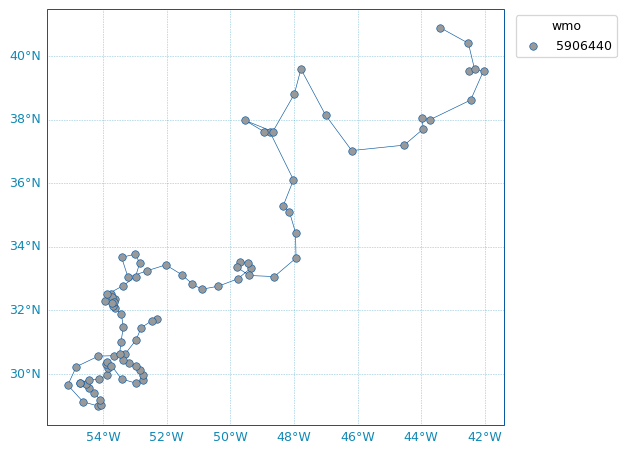

In [14]:
# But here, we use the index retrieved with the DataFetcher:
scatter_map(f.index, set_global=False);

## Make a map with one BGC parameter data mode

We can also make a scatter map with a BGC parameter data mode.

Since the float was randomly selected, we don't know which BGC parameter are available, so randomly select one to work with:

In [15]:
# Randomly select one BGC parameter to work with:
a_param = bgc_params[np.random.randint(len(bgc_params))]
a_param

'PH_IN_SITU_TOTAL'

In [16]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'PH_IN_SITU_TOTAL',
 'prefLabel': 'pH (total scale)',
 'definition': 'pH against the total scale.',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/PH_IN_SITU_TOTAL/'}

In [17]:
# To make the scatter map, we need to have the parameter data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

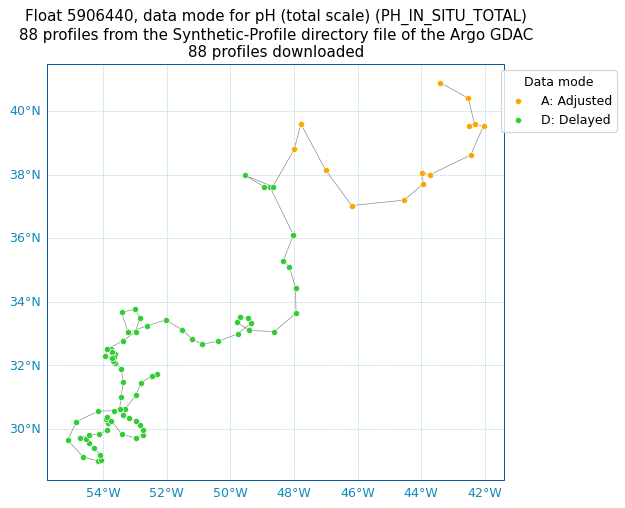

In [18]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Float %i, data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (WMO, param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

## Plot 

### Utilities

We will be using the argopy scatter_plot method that has the following signature:

```
scatter_plot(
    ds: xarray.core.dataset.Dataset,
    this_param,
    this_x='TIME',
    this_y='PRES',
    figsize=(18, 6),
    cmap=None,
    vmin=None,
    vmax=None,
    s=4,
)
```

In [46]:
# Define usefull functions

# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all floats !)
c_bounds = {'BBP700': (20e-5, 150e-5),
            'CDOM': (0, 2.5),
            'CHLA': (0, 1),
            'DOWNWELLING_PAR': (0, 600),
            'DOWN_IRRADIANCE380': (0, 1),
            'DOWN_IRRADIANCE412': (0, 1),
            'DOWN_IRRADIANCE490': (0, 1),
            'DOXY': (150,250),
            'NITRATE': (-2, 20),
            'PH_IN_SITU_TOTAL': (7.8, 8.2)
           }


In [20]:
# We'll make use of the argopy color scheme:
ArgoColors('qc')

### Plot some data QC

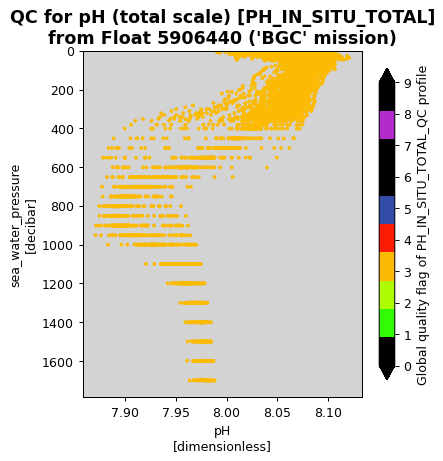

In [21]:
fig, ax = scatter_plot(ds, a_param + '_QC', this_x = a_param, 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for %s [%s]\nfrom Float %i ('%s' mission)" % (param_info['prefLabel'], a_param, WMO, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

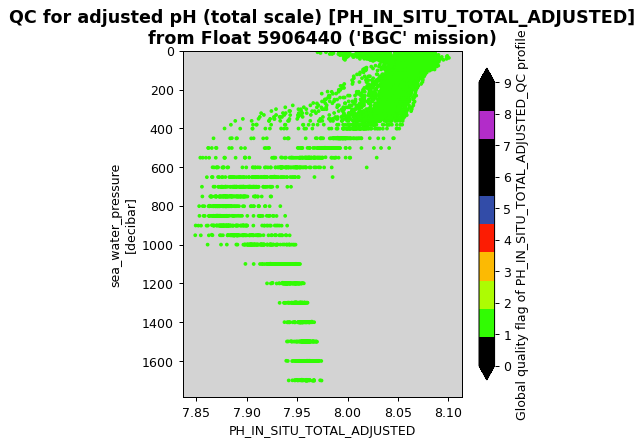

In [34]:
fig, ax = scatter_plot(ds, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))

ax.set_title("QC for adjusted %s [%s]\nfrom Float %i ('%s' mission)" % (param_info['prefLabel'], a_param + '_ADJUSTED', WMO, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

In [35]:
ds['PH_IN_SITU_TOTAL_ADJUSTED'] = ds['PH_IN_SITU_TOTAL_ADJUSTED'].where(ds['PH_IN_SITU_TOTAL_ADJUSTED'] != 99999.)

### Plot some variable against another

7.8


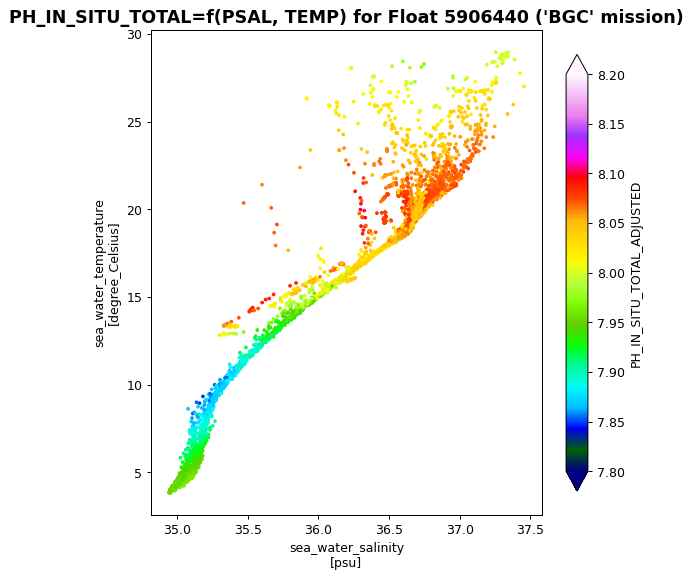

In [41]:
vmin, vmax = c_bounds[a_param] if a_param in c_bounds else (None, None)
print(vmin)
fig, ax = scatter_plot(ds, a_param + '_ADJUSTED', this_x = 'PSAL_ADJUSTED', this_y = 'TEMP_ADJUSTED', 
                       vmin=vmin, vmax=vmax,
                       figsize=(7,7), bgcolor='w')

ax.set_title("%s=f(PSAL, TEMP) for Float %i ('%s' mission)" % (a_param, WMO, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

### Plot time series data

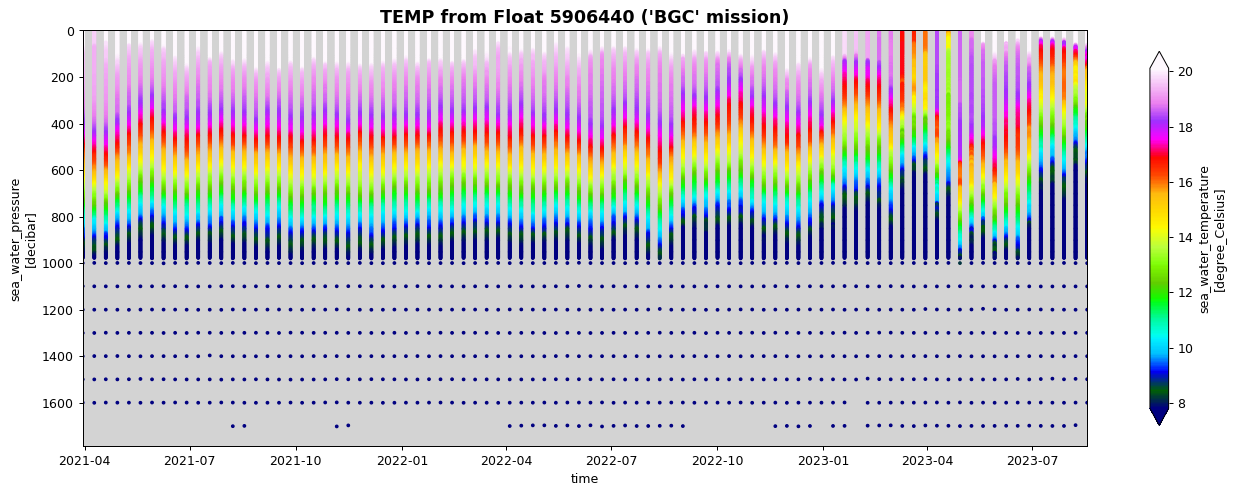

In [42]:
fig, ax = scatter_plot(ds, 'TEMP')
ax.set_title("%s from Float %i ('%s' mission)" % ('TEMP', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

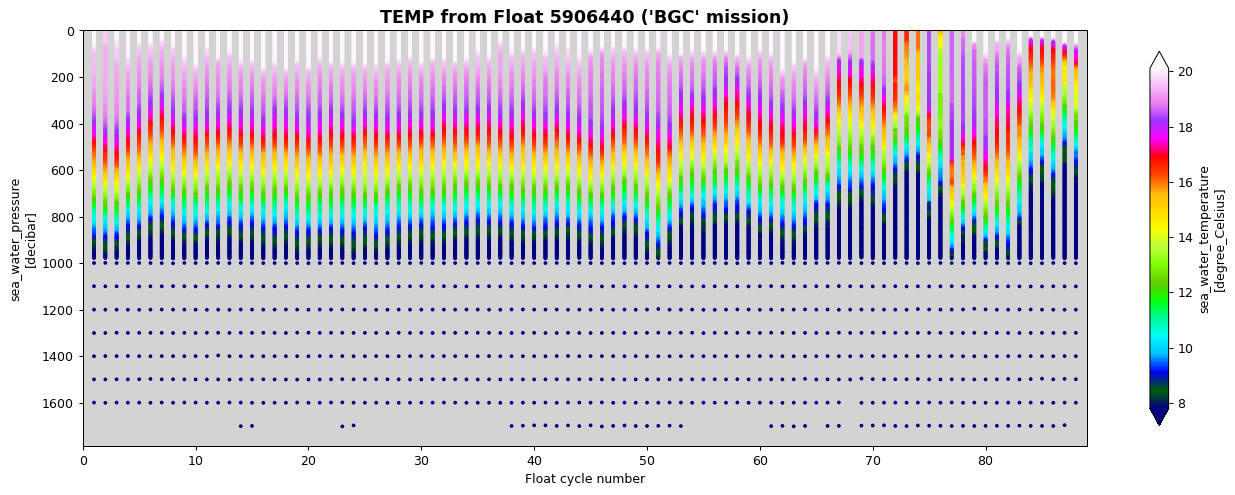

In [43]:
fig, ax = scatter_plot(ds, 'TEMP', this_x='CYCLE_NUMBER')
ax.set_title("%s from Float %i ('%s' mission)" % ('TEMP', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

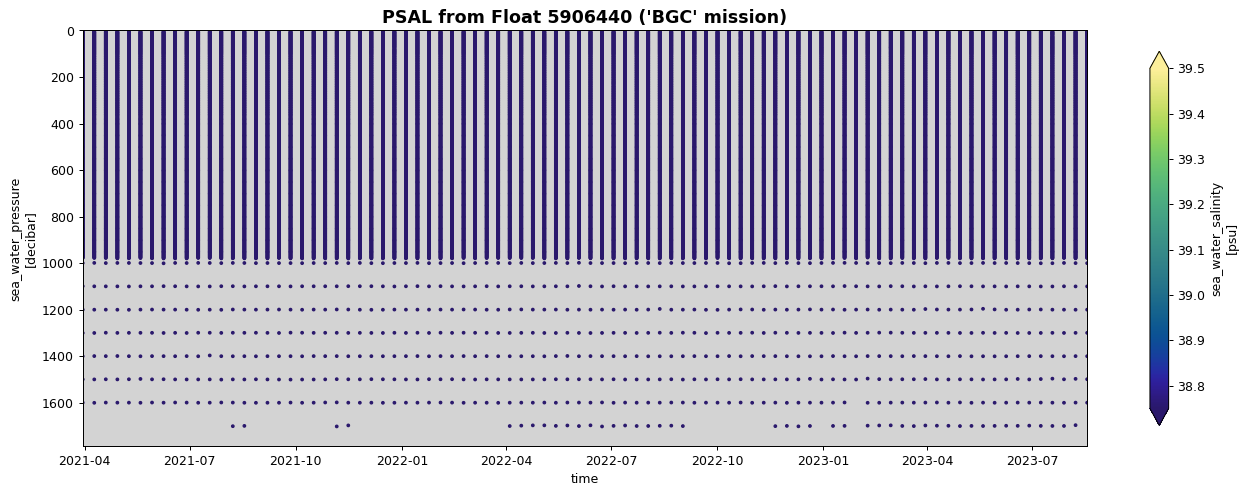

In [44]:
fig, ax = scatter_plot(ds, 'PSAL', cmap=cmocean.cm.haline, vmin=38.75, vmax=39.5)
ax.set_title("%s from Float %i ('%s' mission)" % ('PSAL', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

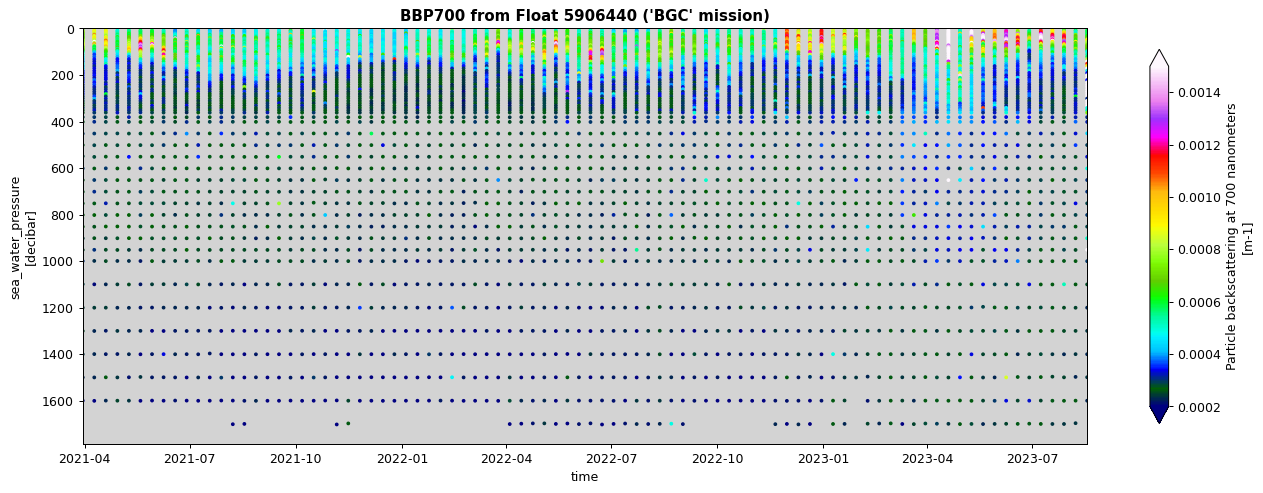

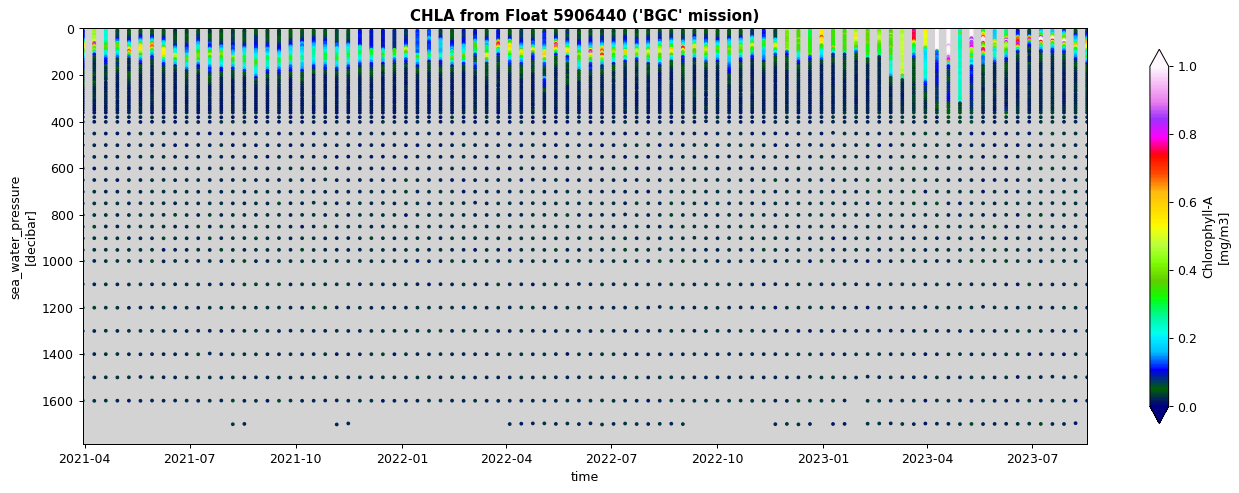

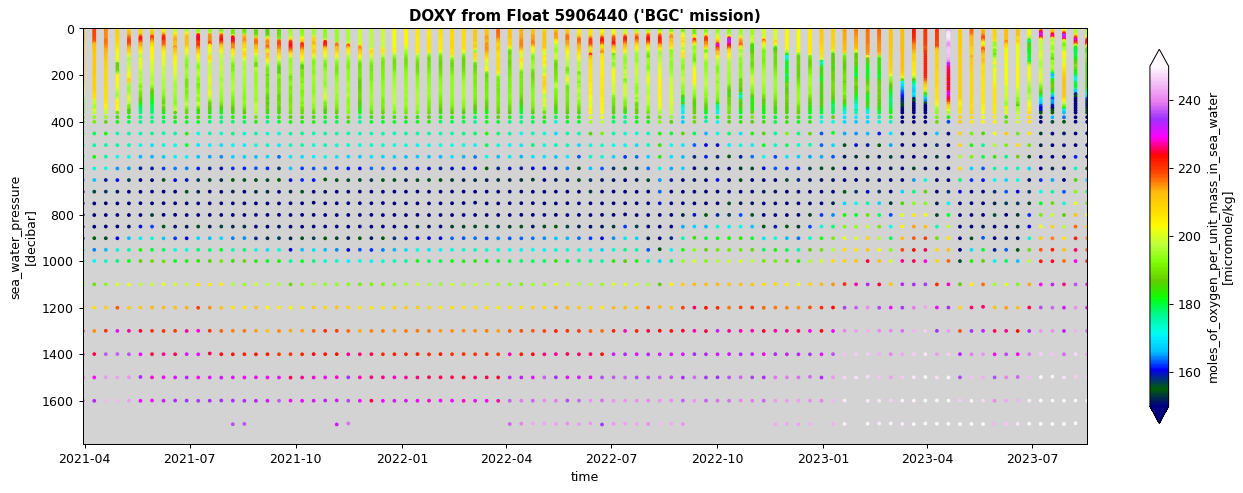

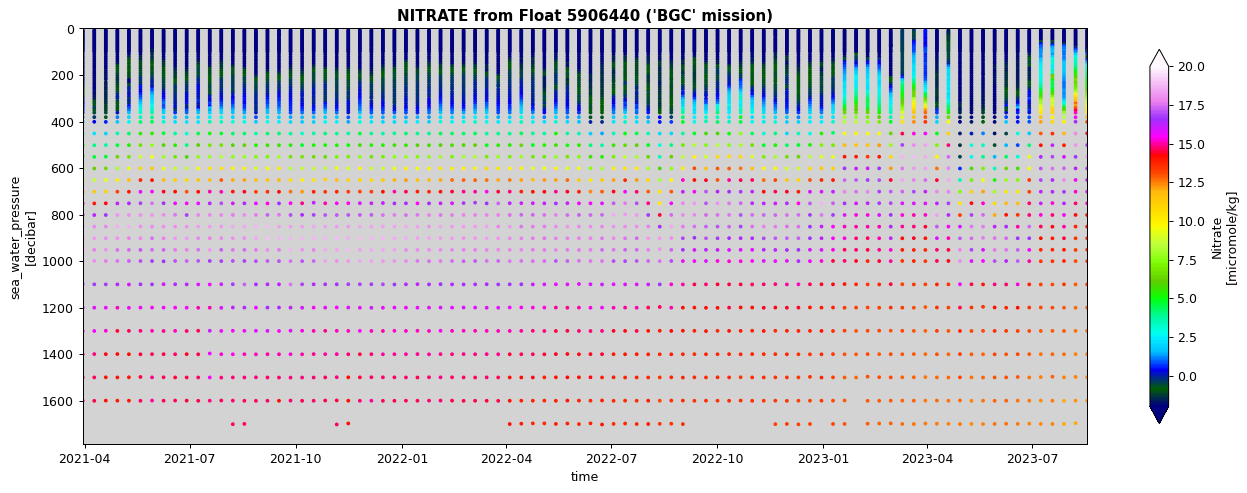

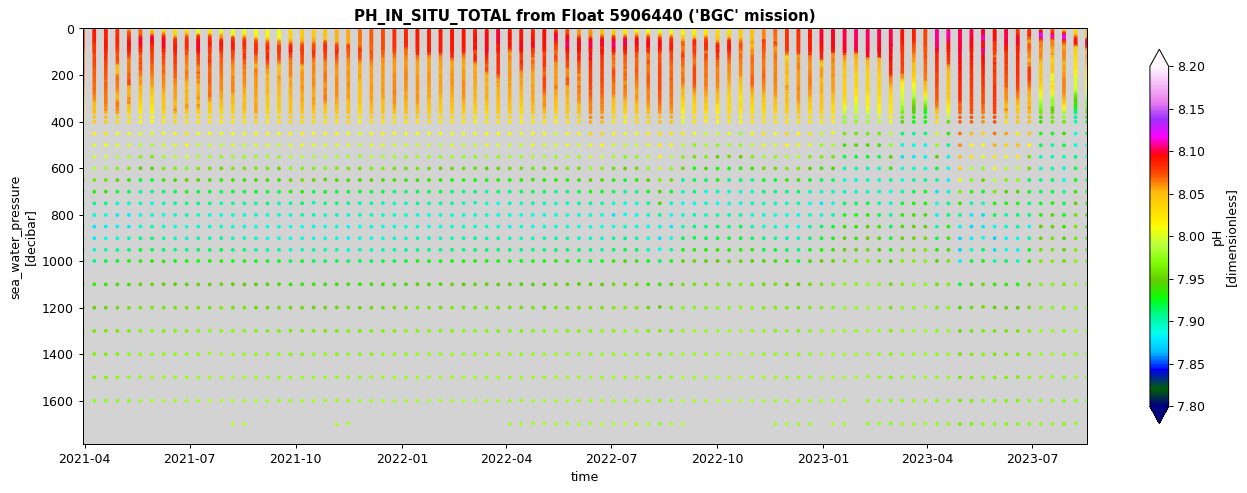

In [47]:
# Plot them all
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(ds, param, vmin=vmin, vmax=vmax)
    ax.set_title("%s from Float %i ('%s' mission)" % (param, WMO, f.mission), fontdict={'weight': 'bold', 'size': 12});

### Plot binned data

Sample dots in regular scatter plots often overlap and it may be hard to get a good sense of the data.

One way to overcome this is to reduce data by pressure bins.

This is a nice method that does not require interpolation.

In [48]:
# Bins data by reducing to the median value in each pressure bins:
bins = np.arange(0.0, np.max(ds["PRES"]), 10.0)
ds_binned = ds.argo.groupby_pressure_bins(bins=bins, select='middle')
ds_binned

/Users/dnicholson/opt/anaconda3/envs/gobgc_ws/lib/python3.11/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


<xarray.Dataset>
Dimensions:                          (N_POINTS: 9239)
Coordinates:
    LONGITUDE                        (N_POINTS) float64 -52.31 -52.31 ... -43.39
    TIME                             (N_POINTS) datetime64[ns] 2021-03-30T09:...
    LATITUDE                         (N_POINTS) float64 31.73 31.73 ... 40.89
    STD_PRES_BINS                    (N_POINTS) float64 0.0 10.0 ... 1.59e+03
  * N_POINTS                         (N_POINTS) int64 0 1 2 3 ... 9236 9237 9238
Data variables: (12/54)
    BBP700                           (N_POINTS) float32 0.0006746 ... 0.0002263
    BBP700_ADJUSTED                  (N_POINTS) float32 0.0006746 ... 0.0002263
    BBP700_ADJUSTED_ERROR            (N_POINTS) float32 1e+05 1e+05 ... 1e+05
    BBP700_ADJUSTED_QC               (N_POINTS) int64 1 0 0 0 1 1 ... 1 1 1 1 1
    BBP700_DATA_MODE                 (N_POINTS) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    BBP700_QC                        (N_POINTS) int64 2 0 0 0 2 2 ... 2 2 2 2 2
    ...                               ...
    TEMP_ADJUSTED                    (N_POINTS) float32 21.02 21.0 ... 4.177
    TEMP_ADJUSTED_ERROR              (N_POINTS) float32 0.002 0.002 ... nan nan
    TEMP_ADJUSTED_QC                 (N_POINTS) int64 8 1 1 1 8 8 ... 1 1 1 1 1
    TEMP_DATA_MODE                   (N_POINTS) <U1 'D' 'D' 'D' ... 'A' 'A' 'A'
    TEMP_QC                          (N_POINTS) int64 8 1 1 1 8 8 ... 1 1 1 1 1
    TIME_QC                          (N_POINTS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
Attributes: (8)

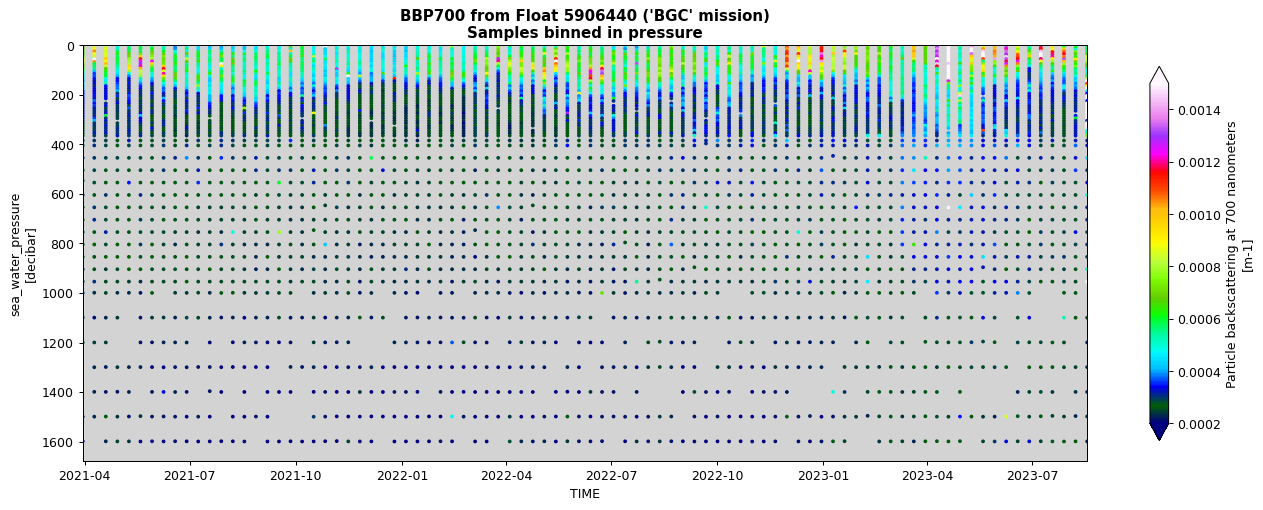

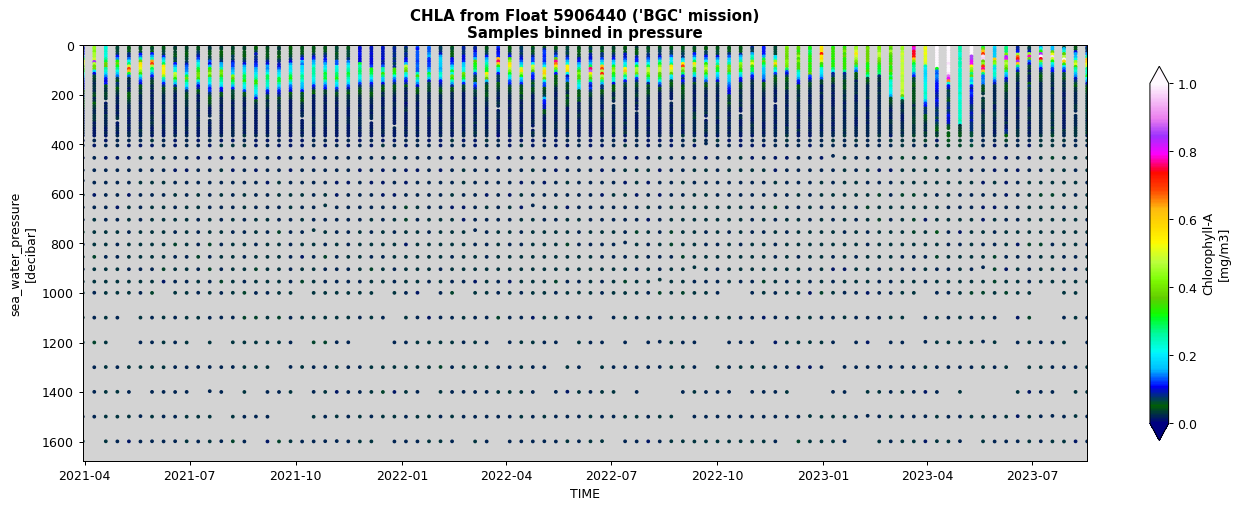

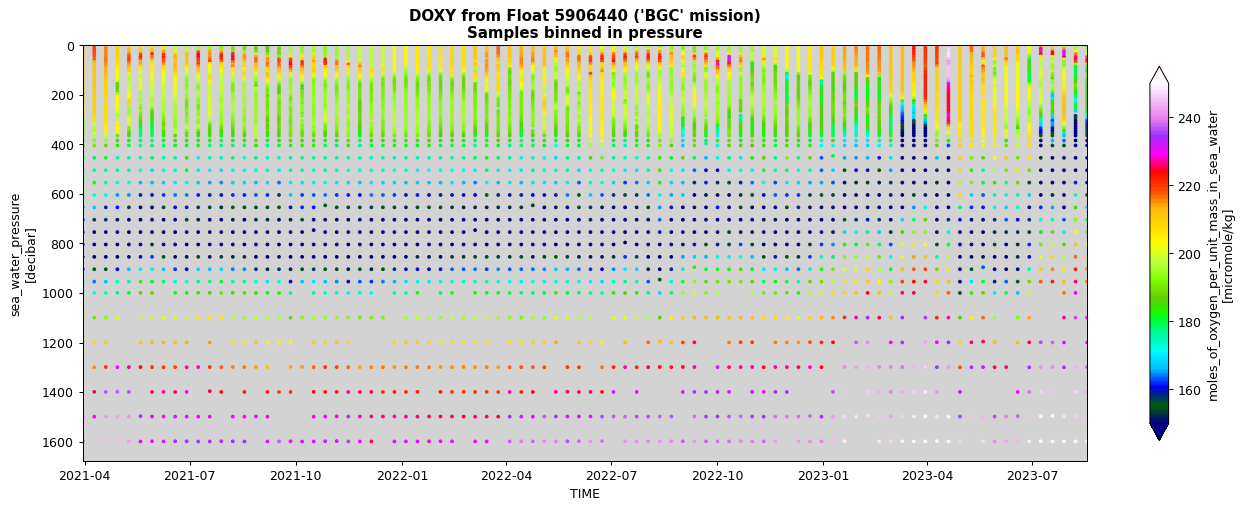

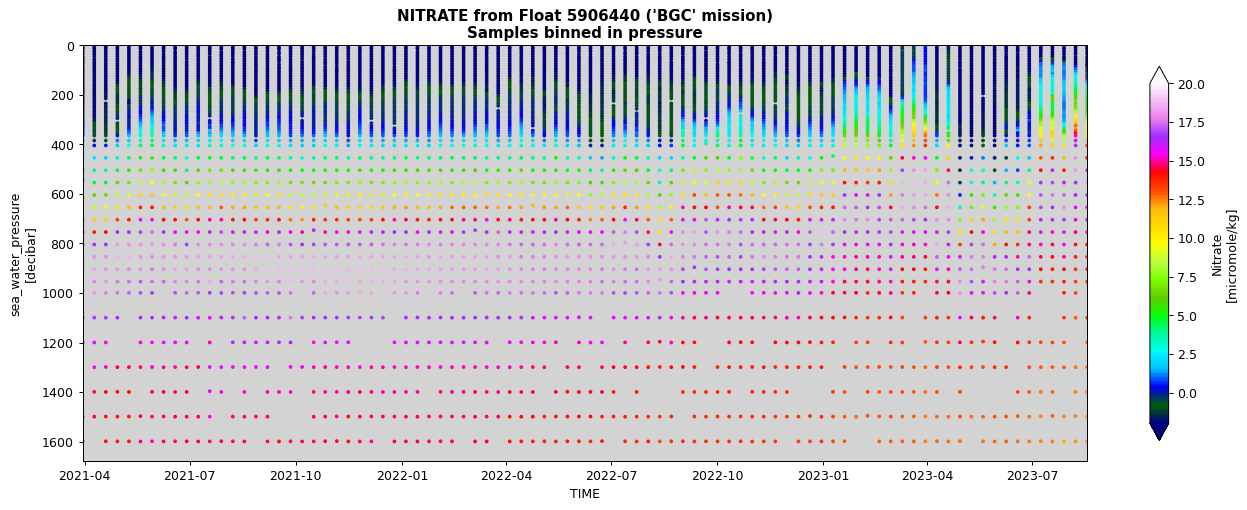

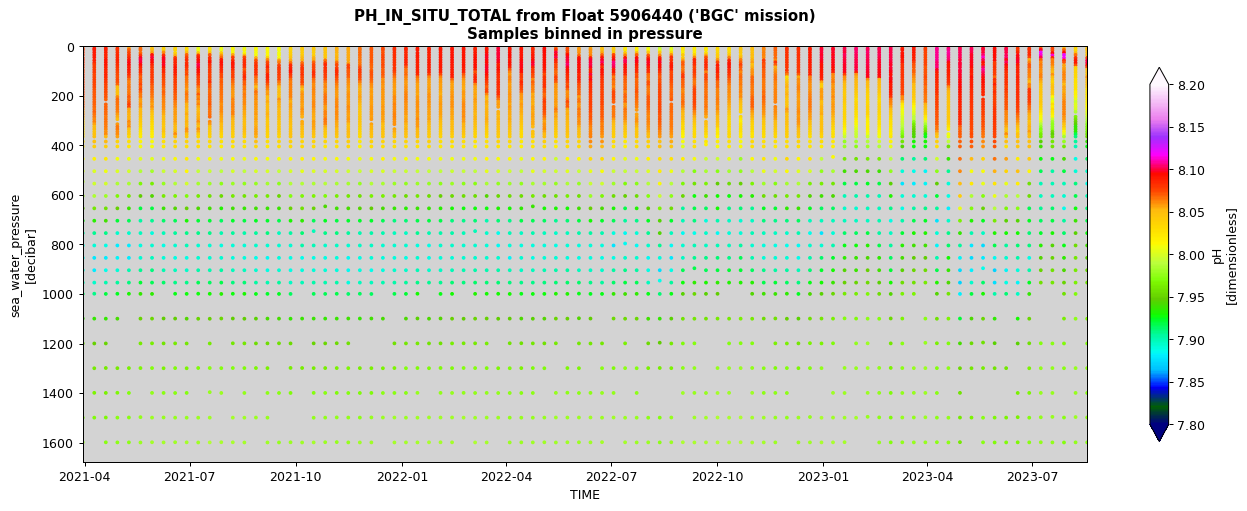

In [49]:
# Plot them all
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(ds_binned, param, vmin=vmin, vmax=vmax)
    ax.set_title("%s from Float %i ('%s' mission)\nSamples binned in pressure" % (param, WMO, f.mission), 
                 fontdict={'weight': 'bold', 'size': 12});

### Plot interpolated data

In [30]:
dsp = ds.argo.point2profile()
# std_lev = np.arange(0, np.round(ds['PRES'].max())-200, 25.0)
std_lev = np.arange(0., 1000., 10.0)
dsi = dsp.argo.interp_std_levels(std_lev)
dsi

<xarray.Dataset>
Dimensions:                     (N_PROF: 88, PRES_INTERPOLATED: 100)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 82 83 84 85 86 87
    LATITUDE                    (N_PROF) float64 31.73 31.67 ... 40.41 40.89
    LONGITUDE                   (N_PROF) float64 -52.31 -52.48 ... -42.51 -43.39
    TIME                        (N_PROF) datetime64[ns] 2021-03-30T09:03:30.0...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) float64 0.0 10.0 ... 990.0
Data variables: (12/28)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0006746...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.1022 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    CHLA_DATA_MODE              (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...                          ...
    PSAL                        (N_PROF, PRES_INTERPOLATED) float32 36.9 ... ...
    PSAL_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 36.9 ... ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'A' 'A' 'A'
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 21.03 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 21.03 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'A' 'A' 'A'
Attributes: (8)

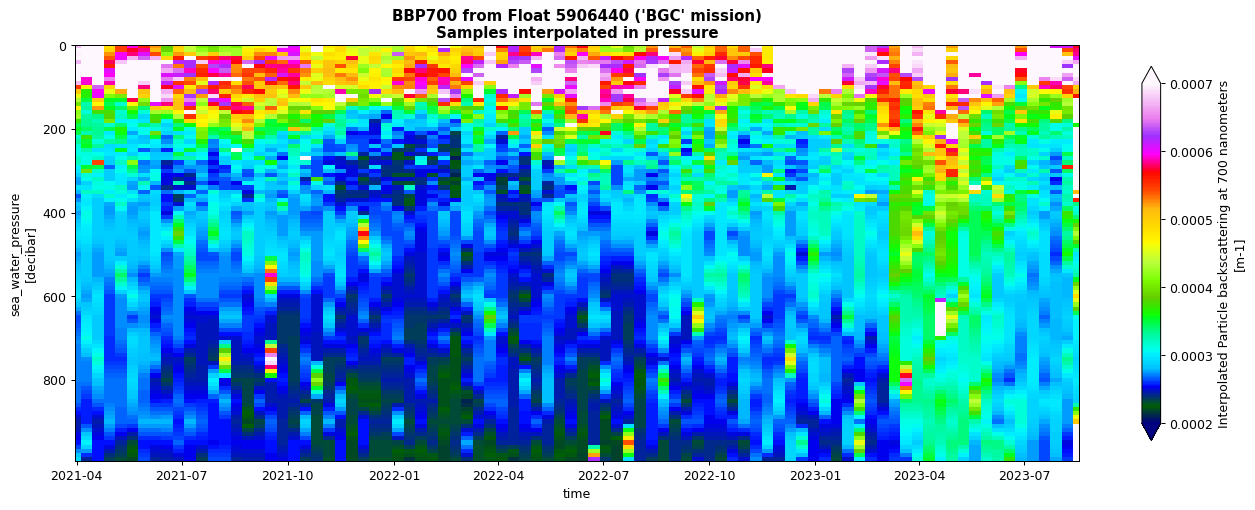

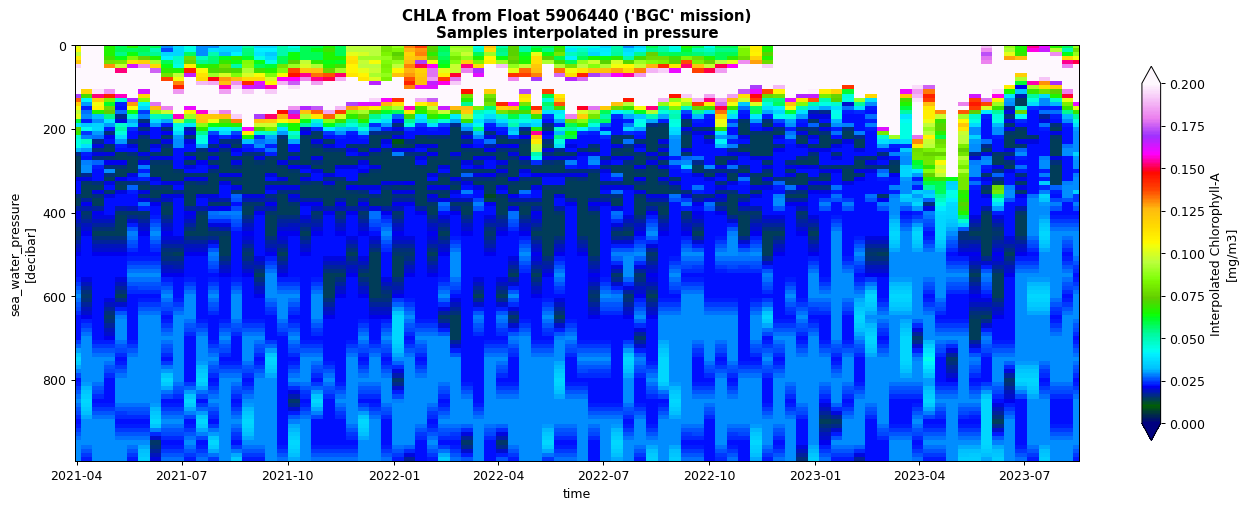

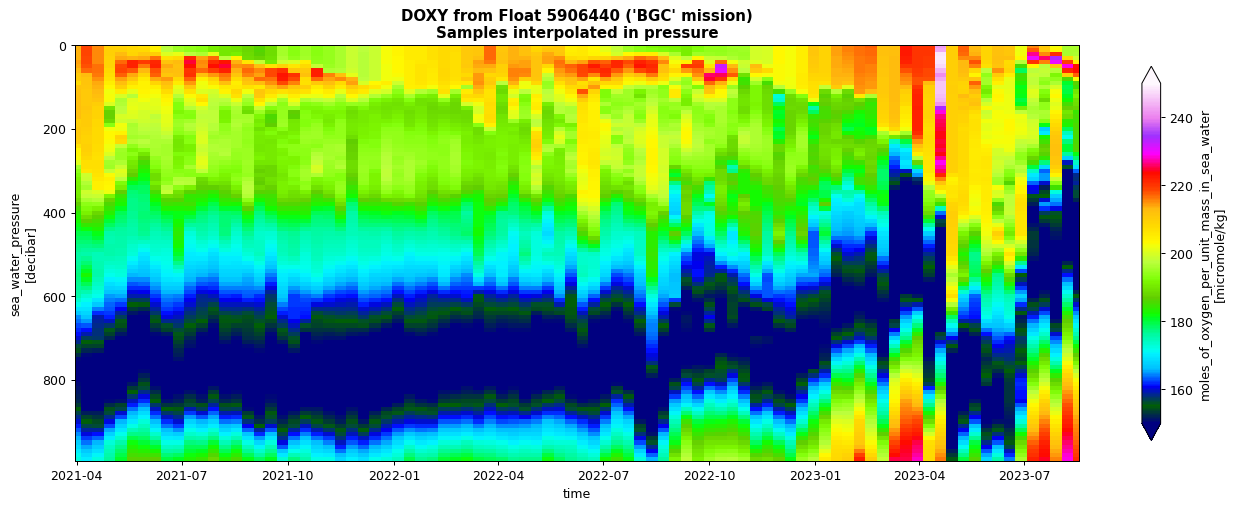

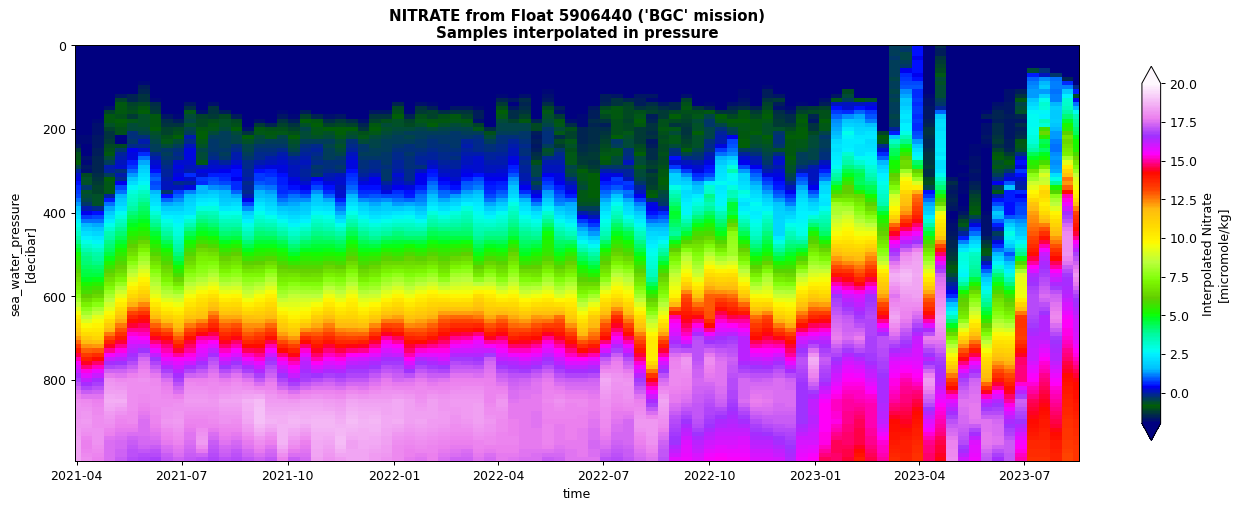

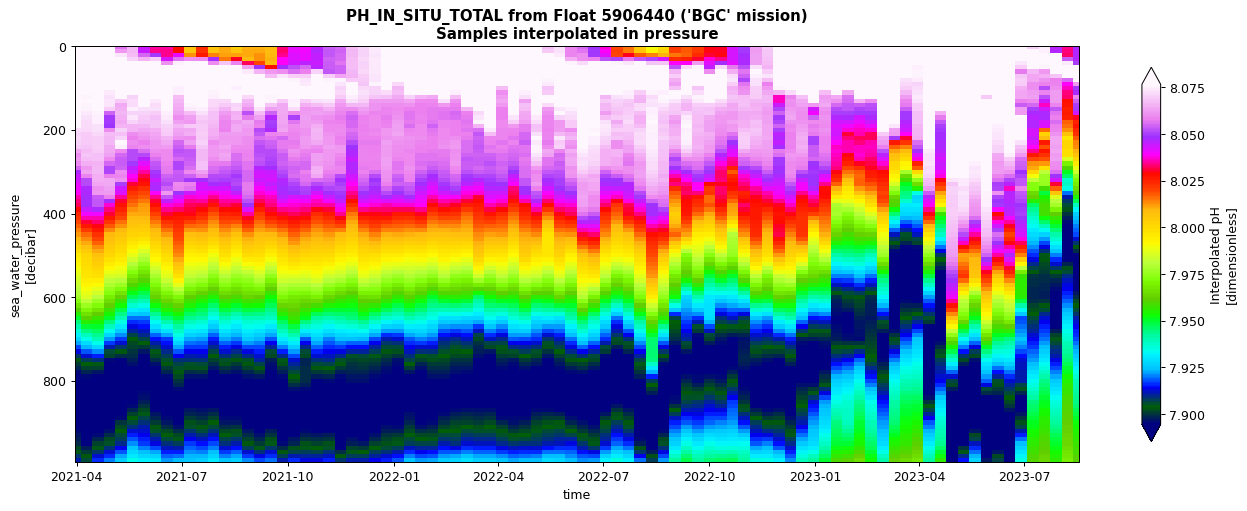

In [31]:
# Plot them all
for param in bgc_params:
# for param in ['CDOM']:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(dsi, param, 
                            this_y='PRES_INTERPOLATED',
                            vmin=vmin, vmax=vmax)
    ax.set_title("%s from Float %i ('%s' mission)\nSamples interpolated in pressure" % (param, WMO, f.mission), 
                 fontdict={'weight': 'bold', 'size': 12});

## Float BGC dashboard

In [32]:
f.dashboard()